In [92]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import cv2
import subprocess

In [43]:
file_name_txt = "DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00001.txt"   # Make sure this is .txt file
with open(file_name_txt,'r') as f:
    content = f.readlines()

In [44]:
df = pd.DataFrame([[float(j) for j in i.split("\t")] for i in content[1:]])
df = df.rename({0: "X-Position", 1: "Y-Position", 2: "U-Displacement", 3: "V-Displacement"}, axis=1)
df

,X-Position,Y-Position,U-Displacement,V-Displacement
0,16.0,16.0,18.6507,-0.308418
1,48.0,16.0,18.2090,-0.602287
2,80.0,16.0,14.1088,-1.770360
3,112.0,16.0,13.8437,-1.979270
4,144.0,16.0,13.9597,-2.043350
...,...,...,...,...
1275,1136.0,1008.0,12.6465,-2.095250
1276,1168.0,1008.0,12.6338,-2.081150
1277,1200.0,1008.0,12.6341,-2.090960
1278,1232.0,1008.0,12.6592,-2.078210


In [45]:
df_filtered = df[(df['U-Displacement'] != 0) & (df['V-Displacement'] != 0)]

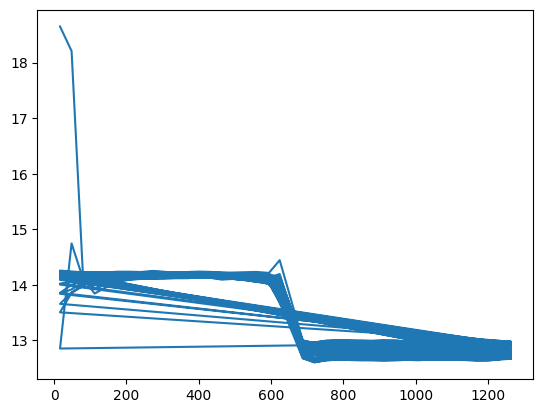

In [46]:
plt.plot(df_filtered["X-Position"], df_filtered["U-Displacement"])

In [ ]:
# the reason for the sharp jump is that the contact material at Interface moved a lot compared to other mateirla sna the DIC was not able to capture it

In [107]:
def infer_plot(file_number: int, output_dir=None, show=True):
    if len(str(file_number)) == 1:
        file_name_txt = f"DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B0000{file_number}.txt"   # Make sure this is .txt file
    elif len(str(file_number)) == 2:
        file_name_txt = f"DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B000{file_number}.txt"   # Make sure this is .txt file
    with open(file_name_txt,'r') as f:
        content = f.readlines()

    df = pd.DataFrame([[float(j) for j in i.split("\t")] for i in content[1:]])
    df = df.rename({0: "X-Position", 1: "Y-Position", 2: "U-Displacement", 3: "V-Displacement"}, axis=1)
        
    # Filter out zero displacement values (masked regions)
    df_filtered = df[(df['U-Displacement'] != 0) & (df['V-Displacement'] != 0)]

    # Create comprehensive plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. U-Displacement vs X-Position (Interface Detection)
    axes[0,0].scatter(df_filtered['X-Position'], df_filtered['U-Displacement'], 
                    c='blue', alpha=0.6, s=20)
    axes[0,0].set_xlabel('X-Position (pixels)')
    axes[0,0].set_ylabel('U-Displacement (pixels)')
    axes[0,0].set_title('U-Displacement vs X-Position\n(Interface Detection)')
    axes[0,0].grid(True, alpha=0.3)

    axes[0,0].set_xlim(0, 1300)     
    axes[0,0].set_ylim(0, 120) 

    # 2. V-Displacement vs X-Position (Critical for Contact Analysis)
    axes[0,1].scatter(df_filtered['X-Position'], df_filtered['V-Displacement'], 
                    c='red', alpha=0.6, s=20)
    axes[0,1].set_xlabel('X-Position (pixels)')
    axes[0,1].set_ylabel('V-Displacement (pixels)')
    axes[0,1].set_title('V-Displacement vs X-Position\n(Contact Interface)')
    axes[0,1].grid(True, alpha=0.3)
 
    axes[0,1].set_xlim(0, 1300)     
    axes[0,1].set_ylim(-1, -30) 

    # 3. Displacement Field Visualization
    scatter = axes[0,2].scatter(df_filtered['X-Position'], df_filtered['Y-Position'], 
                            c=df_filtered['U-Displacement'], cmap='viridis', s=50, vmin=12, vmax=100)
    axes[0,2].set_xlabel('X-Position (pixels)')
    axes[0,2].set_ylabel('Y-Position (pixels)')
    axes[0,2].set_title('U-Displacement Field')
    plt.colorbar(scatter, ax=axes[0,2], label='U-Displacement (pixels)')

    # 4. V-Displacement Field
    scatter2 = axes[1,0].scatter(df_filtered['X-Position'], df_filtered['Y-Position'], 
                                c=df_filtered['V-Displacement'], cmap='plasma', s=50, vmin=-30, vmax=2)
    axes[1,0].set_xlabel('X-Position (pixels)')
    axes[1,0].set_ylabel('Y-Position (pixels)')
    axes[1,0].set_title('V-Displacement Field')
    plt.colorbar(scatter2, ax=axes[1,0], label='V-Displacement (pixels)')

    # 5. Total Displacement Magnitude
    df_filtered['Total_Displacement'] = np.sqrt(df_filtered['U-Displacement']**2 + 
                                            df_filtered['V-Displacement']**2)
    scatter3 = axes[1,1].scatter(df_filtered['X-Position'], df_filtered['Y-Position'], 
                                c=df_filtered['Total_Displacement'], cmap='plasma', s=50, vmin=12, vmax=100)
    axes[1,1].set_xlabel('X-Position (pixels)')
    axes[1,1].set_ylabel('Y-Position (pixels)')
    axes[1,1].set_title('Total Displacement Magnitude')
    plt.colorbar(scatter3, ax=axes[1,1], label='Total Displacement (pixels)')

    # 6. Cross-sectional Analysis (at specific Y-value)
    y_slice = df_filtered['Y-Position'].iloc[0]  # Take first Y value
    df_slice = df_filtered[df_filtered['Y-Position'] == y_slice]
    axes[1,2].plot(df_slice['X-Position'], df_slice['V-Displacement'], 'ro-', 
                label=f'V-Disp at Y={y_slice}')
    axes[1,2].plot(df_slice['X-Position'], df_slice['U-Displacement'], 'bo-', 
                label=f'U-Disp at Y={y_slice}')
    axes[1,2].set_xlabel('X-Position (pixels)')
    axes[1,2].set_ylabel('Displacement (pixels)')
    axes[1,2].set_title(f'Cross-sectional View at Y={y_slice}')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)

    axes[1,2].set_xlim(0, 1300)     
    axes[1,2].set_ylim(-30, 100) 

    fig.suptitle(f"t={file_number}")

    plt.tight_layout()
    
    # SAVE BEFORE SHOWING
    if output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist
        filename = os.path.join(output_dir, f"{file_number}.png")
        fig.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Plot saved as: {filename}")
    if show:
        plt.show()  # Show after saving

    # Additional Analysis: Interface Detection
    print("Data Summary:")
    print(f"U-Displacement range: {df_filtered['U-Displacement'].min():.3f} to {df_filtered['U-Displacement'].max():.3f}")
    print(f"V-Displacement range: {df_filtered['V-Displacement'].min():.3f} to {df_filtered['V-Displacement'].max():.3f}")
    print(f"Total data points: {len(df_filtered)}")

    # Look for potential interfaces (large displacement gradients)
    df_filtered_sorted = df_filtered.sort_values('X-Position')
    u_gradient = np.gradient(df_filtered_sorted['U-Displacement'])
    v_gradient = np.gradient(df_filtered_sorted['V-Displacement'])

    print(f"\nLargest U-displacement gradients at X-positions:")
    max_u_grad_idx = np.argsort(np.abs(u_gradient))[-3:]
    for idx in max_u_grad_idx:
        x_pos = df_filtered_sorted.iloc[idx]['X-Position']
        grad_val = u_gradient[idx]
        print(f"X = {x_pos:.0f}, gradient = {grad_val:.3f}")


In [ ]:
for i in range(1, 25+1): infer_plot(i, "Plots_per_timestep", show=False)

In [109]:
def create_opencv_quicktime_video(image_folder, output_video, fps=2):
    """Create QuickTime-compatible video using OpenCV with proper numerical ordering"""
    
    # Method 1: Use natural sorting with custom key function
    def natural_sort_key(filename):
        """Extract number from filename for proper sorting"""
        import re
        # Extract numbers from filename (assumes format like "1.png", "2.png", etc.)
        numbers = re.findall(r'\d+', os.path.basename(filename))
        return int(numbers[0]) if numbers else 0
    
    # Get all PNG files and sort them numerically
    image_pattern = os.path.join(image_folder, "*.png")
    images = sorted(glob.glob(image_pattern), key=natural_sort_key)
    
    if not images:
        print("No images found!")
        return
    
    print(f"Found {len(images)} images")
    print("First few images in order:")
    for i, img in enumerate(images[:5]):
        print(f"  {i+1}: {os.path.basename(img)}")
    
    # Read first image to get dimensions
    first_image = cv2.imread(images[0])
    height, width, layers = first_image.shape
    
    # Use H.264 codec with proper settings
    fourcc = cv2.VideoWriter_fourcc(*'H264')
    
    # Create temporary AVI first, then convert to MP4
    temp_video = "temp_video.avi"
    video_writer = cv2.VideoWriter(temp_video, fourcc, fps, (width, height))
    
    print(f"Processing {len(images)} images in numerical order...")
    for i, image_path in enumerate(images):
        frame = cv2.imread(image_path)
        if frame is not None:
            video_writer.write(frame)
            if i % 5 == 0:  # Print progress every 5 images
                print(f"Progress: {i+1}/{len(images)} - {os.path.basename(image_path)}")
    
    video_writer.release()
    cv2.destroyAllWindows()
    
    # Convert to QuickTime-compatible MP4 using FFmpeg
    print("Converting to QuickTime-compatible format...")
    cmd = [
        'ffmpeg',
        '-i', temp_video,
        '-c:v', 'libx264',
        '-profile:v', 'main',
        '-pix_fmt', 'yuv420p',
        '-movflags', '+faststart',
        '-y',
        output_video
    ]
    
    try:
        subprocess.run(cmd, check=True, capture_output=True)
        os.remove(temp_video)  # Clean up temporary file
        print(f"✅ QuickTime-compatible video created: {output_video}")
    except subprocess.CalledProcessError as e:
        print(f"❌ Conversion failed: {e}")

# Usage
create_opencv_quicktime_video("Plots_per_timestep", "DIC_opencv_qt.mp4", fps=1)

Found 25 images
First few images in order:
  1: 1.png
  2: 2.png
  3: 3.png
  4: 4.png
  5: 5.png
Processing 25 images in numerical order...
Progress: 1/25 - 1.png
Progress: 6/25 - 6.png
Progress: 11/25 - 11.png
Progress: 16/25 - 16.png
Progress: 21/25 - 21.png
Converting to QuickTime-compatible format...
✅ QuickTime-compatible video created: DIC_opencv_qt.mp4


In [48]:
import os
import glob

def load_dic_file(filename):
    """Load single DIC file"""
    with open(filename, 'r') as f:
        content = f.readlines()
    
    df = pd.DataFrame([[float(j) for j in i.split("\t")] for i in content[1:]])
    df = df.rename({0: "X-Position", 1: "Y-Position", 2: "U-Displacement", 3: "V-Displacement"}, axis=1)
    return df

# Load all files in sequence
file_pattern = "DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B*.txt"
file_list = sorted(glob.glob(file_pattern))

# Store all data
all_data = {}
for i, filename in enumerate(file_list):
    load_step = i + 1  # Load step number
    all_data[load_step] = load_dic_file(filename)
    print(f"Loaded {filename} as load step {load_step}")


Loaded DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00001.txt as load step 1
Loaded DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00002.txt as load step 2
Loaded DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00003.txt as load step 3
Loaded DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00004.txt as load step 4
Loaded DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00005.txt as load step 5
Loaded DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00006.txt as load step 6
Loaded DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00007.txt as load step 7
Loaded DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00008.txt as load step 8
Loaded DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00009.txt as load step 9
Loaded DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00010.txt as load step 10
Loaded DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00011.txt as load step 11
Loaded DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00012.txt as load step 12
Loaded DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00013.tx

In [51]:
all_data

{1:       X-Position  Y-Position  U-Displacement  V-Displacement
 0           16.0        16.0         18.6507       -0.308418
 1           48.0        16.0         18.2090       -0.602287
 2           80.0        16.0         14.1088       -1.770360
 3          112.0        16.0         13.8437       -1.979270
 4          144.0        16.0         13.9597       -2.043350
 ...          ...         ...             ...             ...
 1275      1136.0      1008.0         12.6465       -2.095250
 1276      1168.0      1008.0         12.6338       -2.081150
 1277      1200.0      1008.0         12.6341       -2.090960
 1278      1232.0      1008.0         12.6592       -2.078210
 1279      1264.0      1008.0          0.0000        0.000000
 
 [1280 rows x 4 columns],
 2:       X-Position  Y-Position  U-Displacement  V-Displacement
 0           16.0        16.0         35.4104       -0.515016
 1           48.0        16.0         34.5086       -1.826610
 2           80.0        16.0       